In [ ]:
!pip install nptyping==1.0.1
!pip install SciencePlots
!pip install scikit-image==0.18.2rc1
!pip install matplotlib==3.4.2

     |████████████████████████████████| 45 kB 1.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for SciencePlots: filename=SciencePlots-1.0.9-py3-none-any.whl size=6483 sha256=931de6b45cae6855de9614887526d6595dce336b8119aa87833d746e392e7d72
  Stored in directory: /root/.cache/pip/wheels/37/f8/e9/b2f53a40b336388dfc57b108150daff7d6ffbbfc618dba3924
Successfully built SciencePlots
     |████████████████████████████████| 29.2 MB 85.5 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you h

In [ ]:
import tensorflow as tf

# gpus = tf.config.experimental.list_physical_devices('GPU') 
# for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
from sys import getsizeof

from ipywidgets import interact, interactive
import os
import numpy as np
import sys
import timeit
import csv
sys.path.append('/content/drive/MyDrive/YJ/GP_old')
sys.path.append('/content/drive/MyDrive/YJ/')
sys.path.append('/content/drive/MyDrive/YJ/Green_Stone')
sys.path.append('/content/drive/MyDrive/YJ/Gravity_valid')
import matplotlib.pyplot as plt
import time

import gempy as gp
# from gempy.core.tensor.tensorflow_graph_uncon0 import TFGraph
from gempy.core.grid_modules.grid_types import CenteredGrid,CenteredRegGrid,RegularGrid
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
from gempy import create_data, map_series_to_surfaces
from gempy.assets.geophysics import GravityPreprocessing
from gempy.plot.visualization_2d_pro import *
tfd = tfp.distributions
import seaborn as sns
from GreenStone2 import *
from gravity_util import *
# from ML_grav_kernel import *
tfconstant = constant32

# # %%
# grav_res = 10
# X_r = np.linspace(704000,740000,grav_res)
# Y_r = np.linspace(6.87e6,6.92e6,grav_res)

# r = []
# for x in X_r:
#   for y in Y_r:
#     r.append(np.array([x,y]))
# receivers = np.array(r)
# Z_r = 200
# n_devices = receivers.shape[0]
# xyz = np.meshgrid(X_r, Y_r, Z_r)
# xy_ravel = np.vstack(list(map(np.ravel, xyz))).T

# model1 = Model(receivers = receivers,dtype = 'float32')

In [ ]:

class Optimizing():
  def __init__(self,center_grid_resolution,radius):

    self.radius = tfconstant(radius)
    min_ = -1
    max_ = 1
    self._a = make_variables(tf.cast(center_grid_resolution[0]/2+1,tf.int32),initializer= tf.random_uniform_initializer(minval=min_, maxval=max_, seed=None),dtype = tf.float32)
    self._b = make_variables(tf.cast(center_grid_resolution[1]/2+1,tf.int32),initializer= tf.random_uniform_initializer(minval=min_, maxval=max_, seed=None),dtype = tf.float32)
    self._c = make_variables(tf.cast(center_grid_resolution[2],tf.int32),initializer= tf.random_uniform_initializer(minval=min_, maxval=max_, seed=None),dtype = tf.float32)

  def loss(self,a,b,c):
    tz = compute_tz(a,b,c,self.radius)
    l = tf.math.reduce_std(tz)
    return l

  @tf.function
  def train_step(self,opt):
    with tf.GradientTape() as tape:
      loss_value = self.loss(self._a,self._b,self._c)
      grads = tape.gradient(loss_value,[self._a,self._b,self._c])

    opt.apply_gradients(zip(grads, [self._a,self._b,self._c]))
    return loss_value

  def __call__(self,epochs = 1000):

    opt = tf.keras.optimizers.Adam(
      learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
      name='Adam')

    for epoch in range(epochs):
      # start_time = time.time()
      loss_value = self.train_step(opt)
      if epoch%200==0:
        print("\nStart of epoch %d" % (epoch,))
        print("loss: %.10f" % (float(loss_value),))
        # print("Time taken: %.2fs" % (time.time() - start_time))
    
    return self._a,self._b,self._c


class OptimalGrid(CenteredGrid):
    """
    ML optimized spaced grid.
    """

    def __init__(self, centers=None, radius=None, resolution=None, abc = None):
        super().__init__(centers=None, radius=None, resolution=None)
        self.grid_type = 'centered_grid'
        self.values = np.empty((0, 3))
        self.length = self.values.shape[0]
        self.kernel_centers = np.empty((0, 3))
        self.kernel_dxyz_left = np.empty((0, 3))
        self.kernel_dxyz_right = np.empty((0, 3))
        self.tz = np.empty(0)

        if centers is not None and radius  is not None and abc is None:
            # if resolution is None:
            #     resolution = [10, 10, 20]
            
            f = Optimizing(resolution,radius)
            a,b,c = f(epochs=1000)
            self.abc = [a,b,c]

            self.set_centered_grid( centers = centers,radius=radius, resolution=resolution,a=a,b=b,c=c)
        
        # with a given optimized grid
        elif centers is not None and radius  is not None and abc is not None: 
            a, b, c = [abc[i] for i in range(3)]
            self.set_centered_grid( centers = centers,radius=radius, resolution=resolution,a=a,b=b,c=c)

###################



    @staticmethod
    def create_irregular_grid_kernel(radius,a=None,b=None,c=None):
        """
        Create an isometric grid kernel (centered at 0)

        Args:
            resolution: [s0]
            radius (float): Maximum distance of the kernel

        Returns:
            tuple: center of the voxel, left edge of each voxel (for xyz), right edge of each voxel (for xyz).
        """
        import copy
        if not isinstance(radius, list) or isinstance(radius, np.ndarray):
            radius = np.repeat(radius, 3)

        # a,b,c = find_optimal_grid(a,b,c,epochs)
   
        g_x = tf.cumsum(softmax_space(a))
        g_y = tf.cumsum(softmax_space(b))
        g_z = tf.cumsum(softmax_space(c))

        g2_x = tf.concat((-g_x[::-1], g_x),axis=0) * radius[0]
        g2_y = tf.concat((-g_y[::-1], g_y),axis=0) * radius[1]
        g2_z =  (tf.concat(([0], g_z),axis=0) + 0.005) * - radius[2]

        x_center = (g2_x[:-1]+g2_x[1:])/2 
        y_center = (g2_y[:-1]+g2_y[1:])/2
        z_center = (g2_z[:-1]+g2_z[1:])/2

        g = tf.meshgrid(x_center,y_center,z_center)

        d_left_x = tf.math.abs(g2_x[:-1] - x_center)
        d_left_y = tf.math.abs(g2_y[:-1] - y_center)
        d_right_x = tf.math.abs(g2_x[1:] - x_center)
        d_right_y = tf.math.abs(g2_y[1:] - y_center)
        d_z = z_center - g2_z[:-1]

        d_left = tf.meshgrid(d_left_x,d_left_y,d_z)
        d_right = tf.meshgrid(d_right_x,d_right_y,d_z)

        kernel_g = tf.concat([tf.reshape(g[0],[-1,1]),tf.reshape(g[1],[-1,1]),tf.reshape(g[2],[-1,1])],axis=1)
        kernel_d_left = tf.concat([tf.reshape(d_left[0],[-1,1]),tf.reshape(d_left[1],[-1,1]),tf.reshape(d_left[2],[-1,1])],axis=1)
        kernel_d_right = tf.concat([tf.reshape(d_right[0],[-1,1]),tf.reshape(d_right[1],[-1,1]),tf.reshape(d_right[2],[-1,1])],axis=1)

        return kernel_g.numpy(), kernel_d_left.numpy(), kernel_d_right.numpy()
  

    def set_centered_kernel(self, resolution, radius,a=None,b=None,c=None):
        """
        Set a centered

        Args:
            resolution: [s0]
            radius (float): Maximum distance of the kernel

        Returns:

        """
        self.kernel_centers, self.kernel_dxyz_left, self.kernel_dxyz_right = self.create_irregular_grid_kernel(
             radius,a=a,b=b,c=c)

        return self.kernel_centers


# centered optimized grid
def compute_tz(a,b,c,radius):
  g_x = tf.cumsum(softmax_space(a))
  g_y = tf.cumsum(softmax_space(b))
  g_z = tf.cumsum(softmax_space(c))

  g2_x = tf.concat((-g_x[::-1], g_x),axis=0) * radius[0]
  g2_y = tf.concat((-g_y[::-1], g_y),axis=0) * radius[1]
  g2_z =  (tf.concat(([0], g_z),axis=0) + 0.005) * - radius[2]

  x_center = (g2_x[:-1]+g2_x[1:])/2 
  y_center = (g2_y[:-1]+g2_y[1:])/2
  z_center = (g2_z[:-1]+g2_z[1:])/2

  g = tf.meshgrid(x_center,y_center,z_center)

  d_left_x = tf.math.abs(g2_x[:-1] - x_center)
  d_left_y = tf.math.abs(g2_y[:-1] - y_center)
  d_right_x = tf.math.abs(g2_x[1:] - x_center)
  d_right_y = tf.math.abs(g2_y[1:] - y_center)
  d_z = z_center - g2_z[:-1]

  d_left = tf.meshgrid(d_left_x,d_left_y,d_z)
  d_right = tf.meshgrid(d_right_x,d_right_y,d_z)

  kernel_g = tf.concat([tf.reshape(g[0],[-1,1]),tf.reshape(g[1],[-1,1]),tf.reshape(g[2],[-1,1])],axis=1)
  kernel_d_left = tf.concat([tf.reshape(d_left[0],[-1,1]),tf.reshape(d_left[1],[-1,1]),tf.reshape(d_left[2],[-1,1])],axis=1)
  kernel_d_right = tf.concat([tf.reshape(d_right[0],[-1,1]),tf.reshape(d_right[1],[-1,1]),tf.reshape(d_right[2],[-1,1])],axis=1)

  s_gr_x = kernel_g[:, 0]
  s_gr_y = kernel_g[:, 1]
  s_gr_z = kernel_g[:, 2]

  # # getting the coordinates of the corners of the voxel...
  x_cor = tf.transpose(tf.stack([s_gr_x - kernel_d_left[:, 0], s_gr_x + kernel_d_right[:, 0]], axis=0))
  y_cor = tf.transpose(tf.stack((s_gr_y - kernel_d_left[:, 1], s_gr_y + kernel_d_right[:, 1]), axis=0))
  z_cor = tf.transpose(tf.stack((s_gr_z - kernel_d_left[:, 2], s_gr_z + kernel_d_right[:, 2]), axis=0))

  x_matrix = tf.repeat(x_cor, 4, axis=1)
  y_matrix = tf.tile(tf.repeat(y_cor, 2, axis=1), (1, 2))
  z_matrix = tf.tile(z_cor, (1, 4))

  s_r = tf.sqrt(x_matrix ** 2 + y_matrix ** 2 + z_matrix ** 2)

  mu = tfconstant([1, -1, -1, 1, -1, 1, 1, -1])

  G = tfconstant(6.674e-3)

  tz = (
        G *
        tf.reduce_sum(- 1 *
                mu * (
                        x_matrix * tf.math.log(y_matrix + s_r) +
                        y_matrix * tf.math.log(x_matrix + s_r) -
                        z_matrix * tf.math.atan(x_matrix * y_matrix / (z_matrix * s_r))),
                axis=1))
  return tz

#### convolution spatial method

In [ ]:
class GravityPreprocessingRegAllLoop(RegularGrid):
    def __init__(self, model, regular_grid: RegularGrid = None):

        if regular_grid is None:
            super().__init__()
        elif isinstance(regular_grid, RegularGrid):
            self.model = model
            # self.kernel_centers = np.repeat(regular_grid.values[:,:,np.newaxis],2,axis=2) - model.xy_ravel.T
            self.num_receivers = 1
            # self.kernel_dxyz_right = regular_grid.kernel_dxyz_right
            # self.kernel_dxyz_left = regular_grid.kernel_dxyz_left
        self.tz = np.empty(0)

    def set_tz_kernel(self, model_radius,regular_grid_resolution,scale=True, **kwargs):
        dx, dy, dz = self.model.grid.regular_grid.get_dx_dy_dz()

        # we need to find the closest center for each receiver to keep numerical stability
        # here we find the smallest center which is greater than the receiver coordinates for x and y
        range_xy = [(self.model.extent[1] - self.model.extent[0])/2,(self.model.extent[3] - self.model.extent[2])/2] 
        #center of model
        new_xy_ravel = np.expand_dims(np.array([self.model.extent[0]+range_xy[0],self.model.extent[2]+range_xy[1]]),axis = 1)

        ################
        self.dx = dx
        self.dy = dy
        self.dz = dz
        self.re_x = self.model.xy_ravel.T[0]
        self.re_x = self.re_x + (dx / 2 - (self.re_x-self.model.extent[0]) % dx)

        self.re_y = self.model.xy_ravel.T[1]
        self.re_y = self.re_y + (dy / 2 - (self.re_y-self.model.extent[2]) % dy)

        self.new_xy_ravel = np.stack(
            [
                self.re_x,
                self.re_y,
            ],
            axis=0,
        )
        # concat with z value
        self.new_xy_ravel = np.concatenate(
            [self.new_xy_ravel, self.model.xy_ravel.T[2, None]]
        )

        ################
        # # sensor location move to the next closest cell center
        re_x = new_xy_ravel[0]
        re_x = re_x + (dx / 2 - (re_x-self.model.extent[0]) % dx)

        re_y = new_xy_ravel[1]
        re_y = re_y + (dy / 2 - (re_y-self.model.extent[2]) % dy)

        # concat with z value
        new_xy_ravel_temp = np.concatenate(
            [np.array([re_x,re_y]), np.array([[self.model.extent[-1]]])])

        self.center_index_x = (new_xy_ravel_temp[0]-self.model.extent[0])//dx
        self.center_index_y = (new_xy_ravel_temp[1]-self.model.extent[2])//dy
        self.radius_cell_x = int(self.model.model_radius[0]//dx)
        self.radius_cell_y = int(self.model.model_radius[1]//dy)

        # kernel_centers = np.repeat(self.model.grid.regular_grid.values[:,:,np.newaxis],self.num_receivers,axis=2)-self.model.xy_ravel.T
        kernel_centers = np.squeeze(
                self.model.grid.regular_grid.values[:, :, np.newaxis] - new_xy_ravel_temp
        )

        c_x = int(self.center_index_x[0])
        c_y = int(self.center_index_y[0])

        slice_kernel_centers = (kernel_centers[:,:].reshape(model.regular_grid_resolution+[3,self.num_receivers])[c_x-self.radius_cell_x:c_x+self.radius_cell_x+1,c_y-self.radius_cell_y:c_y+self.radius_cell_y+1,:,:]).reshape([-1,3])


        x_cor = np.stack(
            (slice_kernel_centers[:, 0] - dx / 2, slice_kernel_centers[:, 0] + dx / 2), axis=1
        )
        y_cor = np.stack(
            (slice_kernel_centers[:, 1] - dy / 2, slice_kernel_centers[:, 1] + dy / 2), axis=1
        )
        z_cor = np.stack(
            (slice_kernel_centers[:, 2] + dz / 2, slice_kernel_centers[:, 2] - dz / 2), axis=1
        )

        # ...and prepare them for a vectorial op
        x_matrix = np.repeat(x_cor, 4, axis=1)
        y_matrix = np.tile(np.repeat(y_cor, 2, axis=1), (1, 2))
        z_matrix = np.tile(z_cor, (1, 4)) - 0.005 * (self.model.extent[-1]-self.model.extent[-2])

        s_r = np.sqrt(x_matrix ** 2 + y_matrix ** 2 + z_matrix ** 2)

        # This is the vector that determines the sign of the corner of the voxel
        mu = np.array([1, -1, -1, 1, -1, 1, 1, -1])


        G = 6.674e-3  # ugal     cm3⋅g−1⋅s−26.67408e-2 -- 1 m/s^2 to microgal =

        tz = G * np.sum(
            -1
            * mu
            * (
                x_matrix * np.log(y_matrix + s_r)
                + y_matrix * np.log(x_matrix + s_r)
                - z_matrix * np.arctan(x_matrix * y_matrix / (z_matrix * s_r))
            ),
            axis=1,
        )
        return tz

In [ ]:
# model1 = Model(receivers = receivers,dtype = 'float32',center_grid_resolution=[9,7,50],model_radius=[5000,5000,20200])

In [ ]:
# model1.activate_regular_grid()
# model1.compute_model()

In [ ]:
# p = Plot2D(model1)
# fig, ax = plt.subplots(1,1,figsize = (10,20))
# ax.set_ylim(-20000,0)
# ax.set_xlim(6863000,6930000)
# p.plot_lith(ax,cell_number=[30], direction='x')

In [ ]:
# p = Plot2D(model1)
# # pl = gp.plot.plot_data(model1.geo_data, direction="z") # gempy.plot.plot.plot_data
# ax = plt.gca()
# ax.set_ylim(model1.extent[2],model1.extent[3])
# ax.set_xlim(model1.extent[0],model1.extent[1])
# p.plot_contacts(ax,cell_number=[-1], direction='z')
# ax.scatter(receivers[:,0],receivers[:,1],s=10)
# p.plot_lith(ax,cell_number=[-1], direction='z')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# for i in p._color_lot:
#   ax.scatter([],[],color=p._color_lot[i],label = i)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.yaxis.set_tick_params(rotation=90)
# # plt.savefig('/content/drive/MyDrive/YJ/Green_Stone/figs/lith.png',dpi=500,bbox_inches='tight')

In [ ]:

# p = Plot2D(model1)
# fig, axes = plt.subplots(3,1,figsize = (10,10))
# for e,ax in enumerate(axes):
#   ax.set_ylim(-20000,0)
#   ax.set_xlim(6863000,6930000)
#   p.plot_lith(ax,cell_number=[30], direction='x')
#   p.plot_scalar_field(ax,sn=e,cell_number=model1.regular_grid_resolution[1]//2)

# Gravity

In [ ]:
# grav_res = 10
# X_r = np.linspace(704000,740000,grav_res)
# Y_r = np.linspace(6.87e6,6.92e6,grav_res)

# r = []
# for x in X_r:
#   for y in Y_r:
#     r.append(np.array([x,y]))
# receivers = np.array(r)
# Z_r = 200
# n_devices = receivers.shape[0]
# xyz = np.meshgrid(X_r, Y_r, Z_r)
# xy_ravel = np.vstack(list(map(np.ravel, xyz))).T

## convoluted spatial

In [ ]:

def calculate_grav_convoluted(model):
  model.activate_regular_grid()
  g = GravityPreprocessingRegAllLoop(model,model.grid.regular_grid)
  tz = g.set_tz_kernel(model.model_radius,model.regular_grid_resolution)
  model.geo_data.grid.values = model.geo_data.grid.values - np.array([0,0,0.005 * (g.model.extent[-1]-g.model.extent[-2])])
  model.geo_data.update_from_grid()
  # model.geo_data.rescaling.set_rescaled_grid()
  model.grid = model.geo_data.grid
  model.from_gempy_interpolator()
  Input = model.get_graph_input()
  model.create_tensorflow_graph(Input)
  start = time.time()
  formation_block,property_block,block_mask = model.TFG.compute_series(model.surface_points_coord,
              model.dips_position,
              model.dip_angles,
              model.azimuth,
              model.polarity,
              model.values_properties)

  size = tf.reduce_prod(model.regular_grid_resolution)

  densities = property_block[0:size]

  center_index_x = (g.new_xy_ravel[0]-g.model.extent[0])//g.dx
  center_index_y = (g.new_xy_ravel[1]-g.model.extent[2])//g.dy
  grav_convolution_full = tf.TensorArray(tf.float32, size=n_devices, dynamic_size=False, clear_after_read=True)
  for i in range(n_devices):
    c_x = int(center_index_x[i])
    c_y = int(center_index_y[i])

    windowed_densities = tf.reshape(densities,model.regular_grid_resolution)[c_x-g.radius_cell_x:c_x+g.radius_cell_x+1,c_y-g.radius_cell_y:c_y+g.radius_cell_y+1,:]
    windowed_densities = tf.squeeze(tf.reshape(windowed_densities,(-1,1)))
    grav_ = model.TFG.compute_forward_gravity(tfconstant(tz), 0, size, windowed_densities)
    grav_convolution_full = grav_convolution_full.write(i, grav_)
  grav_convolution_full = tf.squeeze(grav_convolution_full.stack())
  end = time.time()
  print('time covoluted:',end - start)
  print('equivalent center resolutoin: ', g.radius_cell_x*2+1, g.radius_cell_y*2+1)
  return grav_convolution_full, end - start

In [ ]:
def plot_grav(grav_diff,diff = True, ax = None, subplots =False):
  p = Plot2D(model1)
  if ax is None:
    ax = plt.gca()
  f = plt.gcf()
  ax.set_ylim(model1.extent[2],model1.extent[3])
  ax.set_xlim(model1.extent[0],model1.extent[1])
  ax.set_ylabel('Y')
  ax.set_xlabel('X')
  if diff is True:
    vmin = -3
    vmax = 3
  else: 
    vmin=None
    vmax=None
    ax.scatter(receivers[:,0],receivers[:,1],s=10)

  ax.yaxis.set_tick_params(rotation=90)
  p.plot_contacts(ax,cell_number=[-1], direction='z')
  im = ax.imshow(grav_diff.reshape(grav_res,grav_res).T,
            vmin = vmin, vmax = vmax,
            extent=(xy_ravel[:, 0].min() + (xy_ravel[0, 0] - xy_ravel[1, 0]) / 2,
                   xy_ravel[:, 0].max() - (xy_ravel[0, 0] - xy_ravel[1, 0]) / 2,
                   xy_ravel[:, 1].min() + (xy_ravel[0, 1] - xy_ravel[grav_res, 1]) / 2,
                   xy_ravel[:, 1].max() - (xy_ravel[0, 1] - xy_ravel[grav_res, 1]) / 2),
            origin='lower',cmap='viridis_r')
  if subplots is True:
    return im
  f.subplots_adjust(right=0.8)
  cbar = f.colorbar(im)
  cbar.set_label(r'$mgal$',rotation=270)
  return f, ax

In [ ]:
# model = Model(receivers = receivers,dtype = 'float32',center_grid_resolution=[1,1,1],regular_grid_resolution=[400,400,30],model_radius=[5000,5000,20200])

In [ ]:
# grav_convolution_full,_ =  calculate_grav_convoluted(model)
# # relative anomaly
# grav_convolution_full = grav_convolution_full.numpy() - grav_convolution_full.numpy().max()

In [ ]:
# f,ax = plot_grav(grav_convolution_full,diff=False)
# ax.set_title(r'Spatial convolution $ 400 \times 400 \times 30$')

### low resolution convolution

In [ ]:
# regular_grid_resolution_low = [50,50,30]

In [ ]:
# model = Model(receivers = receivers,dtype = 'float32',center_grid_resolution=[1,1,1],regular_grid_resolution=regular_grid_resolution_low,model_radius=[5000,5000,20200])
# grav_convolution_full_low,_ =  calculate_grav_convoluted(model)
# # relative anomaly
# grav_convolution_full_low = grav_convolution_full_low.numpy() - grav_convolution_full_low.numpy().max()

In [ ]:
# plot_grav(grav_convolution_full_low,diff =False)

In [ ]:
# diff_low_full = (grav_convolution_full_low-grav_convolution_full_low.max())-(grav_convolution_full - grav_convolution_full.max())

In [ ]:
# plot_grav(diff_low_full)

## kernel method

In [ ]:
# centered regular grid
# activate the customized grid
def activate_customized_grid(model,grid_kernel):
  model.geo_data.grid.custom_grid=grid_kernel
  model.geo_data.grid.deactivate_all_grids()
  # activate also rescaled the grid
  model.geo_data.grid.set_active('custom')

  model.geo_data.update_from_grid()
  model.geo_data.rescaling.set_rescaled_grid()
  model.grid = model.geo_data.grid
  model.from_gempy_interpolator()
  return model


In [ ]:

def calculate_grav_center_regular(model,grid_kernel ):
  model = activate_customized_grid(model,grid_kernel)
  g_center_regulargrid = GravityPreprocessing(grid_kernel)
  tz_center_regulargrid = tfconstant(g_center_regulargrid.set_tz_kernel())
  input = model.get_graph_input()
  model.create_tensorflow_graph(input)
  start = time.time()
  formation_block,property_block,block_mask = model.TFG.compute_series(model.surface_points_coord,
              model.dips_position,
              model.dip_angles,
              model.azimuth,
              model.polarity,
              model.values_properties)
  size = grid_kernel.values.shape[0]
  densities = property_block[:size]

  gravity_center_reg = model.TFG.compute_forward_gravity(tz_center_regulargrid, 0, size, densities)
  end = time.time()
  print('time:',end - start)
  return gravity_center_reg,end - start

In [ ]:
# centerReg = CenteredRegGrid(model.xy_ravel,radius=[5000,5000,20200],resolution=[9,7,30])
# gravity_center_reg_0,_ = calculate_grav_center_regular(model,centerReg)
# gravity_center_reg_0 = gravity_center_reg_0.numpy() - gravity_center_reg_0.numpy().max()

In [ ]:
# plot_grav(gravity_center_reg_0,diff =False)

In [ ]:
# diff_cr_full = (gravity_center_reg_0)-(grav_convolution_full )

In [ ]:
# plot_grav(diff_cr_full)

In [ ]:
# centerML = OptimalGrid(model.xy_ravel,radius=[5000,5000,20200],resolution=[9,7,30])

# gravity_center_ml,_ = calculate_grav_center_regular(model,centerML)

In [ ]:
# # centered_optimal_grid
# diff_co_full = (gravity_center_ml.numpy()-gravity_center_ml.numpy().max())-(grav_convolution_full - grav_convolution_full.max())

In [ ]:
# plot_grav(diff_co_full)

In [ ]:
# rmse_low_full = tf.sqrt(tf.reduce_mean(diff_low_full**2)).numpy()

In [ ]:
# rmse_cr = tf.sqrt(tf.reduce_mean(diff_cr_full**2)).numpy()

In [ ]:
# rmse_co = tf.sqrt(tf.reduce_mean(diff_co_full**2)).numpy()

In [ ]:
# fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
#                                     figsize=(18, 6))
# plot_grav(diff_low_full,ax = ax0, diff=True,subplots=True)
# plot_grav(diff_cr_full,ax = ax1, diff=True,subplots=True)
# im = plot_grav(diff_co_full,ax = ax2, diff=True,subplots=True)
# ax0.set_title(r'Spatial convolution $ 50 \times 50 $' +'\n RMSE: %1.3f'% rmse_low_full)
# ax1.set_title(r'Kernel regular grid $ 9 \times 7 $'+'\n RMSE: %1.3f'% rmse_cr)
# ax2.set_title(r'Kernel optimized grid $ 9 \times 7 $'+'\n RMSE: %1.3f'% rmse_co)
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.7])
# fig.colorbar(im, cax=cbar_ax)
# cbar_ax.set_ylabel('$mgal$', rotation=270,labelpad=15)


# complexity

In [ ]:
# %%
time_cov_list = []
time_kernel_list = []
for i in range(1,41):
  X_r = np.linspace(704000,740000,10)
  Y_r = np.linspace(6.87e6,6.92e6,i)

  r = []
  for x in X_r:
    for y in Y_r:
      r.append(np.array([x,y]))
  receivers = np.array(r)
  Z_r = 200
  n_devices = receivers.shape[0]
  xyz = np.meshgrid(X_r, Y_r, Z_r)
  xy_ravel = np.vstack(list(map(np.ravel, xyz))).T
  model = Model(receivers = receivers,dtype = 'float32',center_grid_resolution=[1,1,1],regular_grid_resolution=[50,50,30],model_radius=[5000,5000,20200])
  centerReg = CenteredRegGrid(model.xy_ravel,radius=[5000,5000,20200],resolution=[9,7,30])
  _,time_cov = calculate_grav_convoluted(model)
  _,time_kernel = calculate_grav_center_regular(model,centerReg)
  time_cov_list.append(time_cov)
  time_kernel_list.append(time_kernel)

Active grids: ['regular']
Active grids: ['regular' 'sections']
time covoluted: 3.6382720470428467
equivalent center resolutoin:  9 7
time: 0.2074129581451416
Active grids: ['regular']
Active grids: ['regular' 'sections']
time covoluted: 0.2560739517211914
equivalent center resolutoin:  9 7
time: 0.22203302383422852
Active grids: ['regular']
Active grids: ['regular' 'sections']
time covoluted: 0.27686429023742676
equivalent center resolutoin:  9 7
time: 0.21207475662231445
Active grids: ['regular']
Active grids: ['regular' 'sections']
time covoluted: 0.2893505096435547
equivalent center resolutoin:  9 7
time: 0.2127525806427002
Active grids: ['regular']
Active grids: ['regular' 'sections']
time covoluted: 0.31884074211120605
equivalent center resolutoin:  9 7
time: 0.21477770805358887
Active grids: ['regular']
Active grids: ['regular' 'sections']
time covoluted: 0.32686710357666016
equivalent center resolutoin:  9 7
time: 0.2212381362915039
Active grids: ['regular']
Active grids: ['regu

In [ ]:
plt.plot(time_cov_list,label='cov')
plt.plot(time_kernel_list,label = 'kernel')
plt.legend()

In [ ]:
model = Model(receivers = receivers,dtype = 'float32',center_grid_resolution=[1,1,1],regular_grid_resolution=[50,50,30],model_radius=[5000,5000,20200])
centerReg = CenteredRegGrid(model.xy_ravel,radius=[5000,5000,20200],resolution=[9,7,30])
model = activate_customized_grid(model,centerReg)
g_center_regulargrid = GravityPreprocessing(centerReg)
tz_center_regulargrid = tfconstant(g_center_regulargrid.set_tz_kernel())
input = model.get_graph_input()
model.create_tensorflow_graph(input,gradient = True)

@tf.function
def forward_kernel(mu,model):
  TFG = TFGraph(input, model.fault_drift,
                    model.grid_tensor, model.values_properties, model.nugget_effect_grad,model.nugget_effect_scalar, model.Range,
                    model.C_o, model.rescale_factor,slope = 10, dtype = model.tfdtype, gradient = True)
  formation_block,property_block,block_mask = TFG.compute_series(mu,
              model.dips_position,
              model.dip_angles,
              model.azimuth,
              model.polarity,
              model.values_properties)
  size = centerReg.values.shape[0]
  densities = property_block[:size]

  gravity_center_reg = model.TFG.compute_forward_gravity(tz_center_regulargrid, 0, size, densities)

  print('tracing kernel forwad')
  tf.print('executing kernel forwad')

  return formation_block

Active grids: ['regular']
Active grids: ['regular' 'sections']


In [ ]:
# start_time = time.time()
# forward_kernel(model.surface_points_coord,model)
# print("--- %s seconds ---" % (time.time() - start_time))
# start_time = time.time()
# forward_kernel(model.surface_points_coord,model)
# print("--- %s seconds ---" % (time.time() - start_time))
# start_time = time.time()
# forward_kernel(model.surface_points_coord,model)
# print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# forward_kernel(model.surface_points_coord)

In [ ]:
# forward_cov(model.surface_points_coord)

convolution forward

In [ ]:
model.activate_regular_grid()
g = GravityPreprocessingRegAllLoop(model,model.grid.regular_grid)
tz = g.set_tz_kernel(model.model_radius,model.regular_grid_resolution)
input = model.get_graph_input()
model.create_tensorflow_graph(input,gradient = True)
@tf.function
def forward_cov(mu,model):
    TFG = TFGraph(input, model.fault_drift,
                    model.grid_tensor, model.values_properties, model.nugget_effect_grad,model.nugget_effect_scalar, model.Range,
                    model.C_o, model.rescale_factor,slope = 1, dtype = model.tfdtype, gradient = True)
    
    formation_block,property_block,block_mask =TFG.compute_series(mu,
                model.dips_position,
                model.dip_angles,
                model.azimuth,
                model.polarity,
                model.values_properties)

    size = tf.reduce_prod(model.regular_grid_resolution)

    densities = property_block[0:size]

    center_index_x = tf.constant((g.new_xy_ravel[0]-g.model.extent[0])//g.dx,tf.float32)
    center_index_y = tf.constant((g.new_xy_ravel[1]-g.model.extent[2])//g.dy,tf.float32)
    grav_convolution_full = tf.TensorArray(tf.float32, size=n_devices, dynamic_size=False, clear_after_read=True)
    for i in tf.range(n_devices):
      c_x = tf.cast(center_index_x[i],tf.int32)
      c_y = tf.cast(center_index_y[i],tf.int32)

      windowed_densities = tf.reshape(densities,model.regular_grid_resolution)[c_x-g.radius_cell_x:c_x+g.radius_cell_x+1,c_y-g.radius_cell_y:c_y+g.radius_cell_y+1,:]
      windowed_densities = tf.squeeze(tf.reshape(windowed_densities,(-1,1)))
      grav_ = TFG.compute_forward_gravity(tfconstant(tz), 0, size, windowed_densities)
      grav_convolution_full = grav_convolution_full.write(i, grav_)
    grav_convolution_full = tf.squeeze(grav_convolution_full.stack())
    print('tracing convolution forward')
    tf.print('executing convolution forward')
    return formation_block

In [ ]:
# start_time = time.time()
# forward_cov(model.surface_points_coord,model)
# print("--- %s seconds ---" % (time.time() - start_time))
# start_time = time.time()
# forward_cov(model.surface_points_coord,model)
# print("--- %s seconds ---" % (time.time() - start_time))
# start_time = time.time()
# forward_cov(model.surface_points_coord,model)
# print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# %%
time_cov_list = []
time_kernel_list = []
for i in range(1,100,5):
# for i in range(1,2):

  X_r = np.linspace(704000,740000,2)
  Y_r = np.linspace(6.87e6,6.92e6,i)

  r = []
  for x in X_r:
    for y in Y_r:
      r.append(np.array([x,y]))
  receivers = np.array(r)
  Z_r = 200
  n_devices = receivers.shape[0]
  xyz = np.meshgrid(X_r, Y_r, Z_r)
  xy_ravel = np.vstack(list(map(np.ravel, xyz))).T
  model = Model(receivers = receivers,dtype = 'float32',center_grid_resolution=[1,1,1],regular_grid_resolution=[150,150,30],model_radius=[5000,5000,20200])
  ### kernel
  centerReg = CenteredRegGrid(model.xy_ravel,radius=[5000,5000,20200],resolution=[9,7,30])
  model = activate_customized_grid(model,centerReg)
  g_center_regulargrid = GravityPreprocessing(centerReg)
  tz_center_regulargrid = tfconstant(g_center_regulargrid.set_tz_kernel())
  input = model.get_graph_input()
  model.create_tensorflow_graph(input,gradient = True)

  # compile kernel
  forward_kernel(model.surface_points_coord,model)
  start_time = time.time()
  forward_kernel(model.surface_points_coord,model)
  time_kernel_list.append(time.time() - start_time)


  ### convolution
  model.activate_regular_grid()
  g = GravityPreprocessingRegAllLoop(model,model.grid.regular_grid)
  tz = g.set_tz_kernel(model.model_radius,model.regular_grid_resolution)
  input = model.get_graph_input()
  model.create_tensorflow_graph(input,gradient = True)

  # compile convolution
  forward_cov(model.surface_points_coord,model)
  start_time = time.time()
  forward_cov(model.surface_points_coord,model)
  time_cov_list.append(time.time() - start_time)


Active grids: ['regular']
Active grids: ['regular' 'sections']
tracing kernel forwad
executing kernel forwad
executing kernel forwad
tracing convolution forward
executing convolution forward
executing convolution forward
Active grids: ['regular']
Active grids: ['regular' 'sections']
tracing kernel forwad
executing kernel forwad
executing kernel forwad
tracing convolution forward
executing convolution forward
executing convolution forward
Active grids: ['regular']
Active grids: ['regular' 'sections']
tracing kernel forwad
executing kernel forwad
executing kernel forwad
tracing convolution forward
executing convolution forward
executing convolution forward
Active grids: ['regular']
Active grids: ['regular' 'sections']
tracing kernel forwad
executing kernel forwad
executing kernel forwad
tracing convolution forward
executing convolution forward
executing convolution forward
Active grids: ['regular']
Active grids: ['regular' 'sections']
tracing kernel forwad
executing kernel forwad
executi

In [ ]:
plt.plot(time_cov_list,'.-',label = 'cov')
plt.plot(time_kernel_list,'.-',label = 'kernel')
plt.legend()

In [ ]:
# avg_time_forward_cov = sum(time_cov_list)/len(time_cov_list)
# avg_time_forward_cov

In [ ]:
# avg_time_forward_kernel = sum(time_kernel_list)/len(time_kernel_list)
# avg_time_forward_kernel

# AD

In [ ]:
# X_r = np.linspace(704000,740000,10)
# Y_r = np.linspace(6.87e6,6.92e6,1)

# r = []
# for x in X_r:
#   for y in Y_r:
#     r.append(np.array([x,y]))
# receivers = np.array(r)
# Z_r = 200
# n_devices = receivers.shape[0]

In [ ]:
# model = Model(receivers = receivers,dtype = 'float32',center_grid_resolution=[1,1,1],regular_grid_resolution=[50,50,30],model_radius=[5000,5000,20200])
# centerReg = CenteredRegGrid(model.xy_ravel,radius=[5000,5000,20200],resolution=[9,7,30])


In [ ]:
# model = activate_customized_grid(model,centerReg)
# g_center_regulargrid = GravityPreprocessing(centerReg)
# tz_center_regulargrid = tfconstant(g_center_regulargrid.set_tz_kernel())
# input = model.get_graph_input()
# model.create_tensorflow_graph(input,gradient = True)
@tf.function
def grad_func_kernel(mu,model):
  with tf.GradientTape() as t:
    t.watch(mu)
    TFG = TFGraph(input, model.fault_drift,
                    model.grid_tensor, model.values_properties, model.nugget_effect_grad,model.nugget_effect_scalar, model.Range,
                    model.C_o, model.rescale_factor,slope = 10, dtype = model.tfdtype, gradient = True)
    formation_block,property_block,block_mask = TFG.compute_series(mu,
                model.dips_position,
                model.dip_angles,
                model.azimuth,
                model.polarity,
                model.values_properties)
    size = centerReg.values.shape[0]
    densities = property_block[:size]

    gravity_center_reg = model.TFG.compute_forward_gravity(tz_center_regulargrid, 0, size, densities)
    # print('tracing')
    # tf.print('executing')
  grad = t.gradient(gravity_center_reg,mu)
  return grad

In [ ]:
# start_time = time.time()
# grad_func_kernel(model.surface_points_coord,model)
# print("--- %s seconds ---" % (time.time() - start_time))
# start_time = time.time()
# grad_func_kernel(model.surface_points_coord,model)
# print("--- %s seconds ---" % (time.time() - start_time))
# start_time = time.time()
# grad_func_kernel(model.surface_points_coord,model)
# print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# model = activate_customized_grid(model,centerReg)
# g_center_regulargrid = GravityPreprocessing(centerReg)
# tz_center_regulargrid = tfconstant(g_center_regulargrid.set_tz_kernel())
# input = model.get_graph_input()
# model.create_tensorflow_graph(input,gradient = True)
# # @tf.function
# def hvp(mu,tangents):
#     with tf.autodiff.ForwardAccumulator(mu, tangents) as acc:
#         with tf.GradientTape(watch_accessed_variables=False) as t:
#             t.watch(mu)
#             TFG = TFGraph(input, model.fault_drift,
#                             model.grid_tensor, model.values_properties, model.nugget_effect_grad,model.nugget_effect_scalar, model.Range,
#                             model.C_o, model.rescale_factor,slope = 10, dtype = model.tfdtype, gradient = True)
#             formation_block,property_block,block_mask = TFG.compute_series(mu,
#                         model.dips_position,
#                         model.dip_angles,
#                         model.azimuth,
#                         model.polarity,
#                         model.values_properties)
#             size = centerReg.values.shape[0]
#             densities = property_block[:size]
#             print('tracing')
#             tf.print('executing')

#             gravity_center_reg = model.TFG.compute_forward_gravity(tz_center_regulargrid, 0, size, densities)
#         loss = t.gradient(gravity_center_reg,mu)
#     hess = acc.jvp(loss)
#     return(hess)

In [ ]:
# mu = model.surface_points_coord
# tangents = np.zeros(mu.shape)
# tangents[0]=1
# tangents = tf.convert_to_tensor(tangents,dtype=tf.float32)
# start_time = time.time()
# hvp(mu,tangents)
# print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# start_time = time.time()
# hvp(mu,tangents)
# print("--- %s seconds ---" % (time.time() - start_time))
# start_time = time.time()
# hvp(mu,tangents)
# print("--- %s seconds ---" % (time.time() - start_time))
# start_time = time.time()
# hvp(mu,tangents)
# print("--- %s seconds ---" % (time.time() - start_time))

The above first order works perfectly, but second order derivative is problematic

Convolution scheme

In [ ]:
# model.activate_regular_grid()
# g = GravityPreprocessingRegAllLoop(model,model.grid.regular_grid)
# tz = g.set_tz_kernel(model.model_radius,model.regular_grid_resolution)
# input = model.get_graph_input()
# model.create_tensorflow_graph(input,gradient = True)
@tf.function
def grad_func(mu,model):
  with tf.GradientTape() as t:
    t.watch(mu)
    TFG = TFGraph(input, model.fault_drift,
                    model.grid_tensor, model.values_properties, model.nugget_effect_grad,model.nugget_effect_scalar, model.Range,
                    model.C_o, model.rescale_factor,slope = 1, dtype = model.tfdtype, gradient = True)
    formation_block,property_block,block_mask =TFG.compute_series(mu,
                model.dips_position,
                model.dip_angles,
                model.azimuth,
                model.polarity,
                model.values_properties)

    size = tf.reduce_prod(model.regular_grid_resolution)

    densities = property_block[0:size]

    center_index_x = tf.constant((g.new_xy_ravel[0]-g.model.extent[0])//g.dx,tf.float32)
    center_index_y = tf.constant((g.new_xy_ravel[1]-g.model.extent[2])//g.dy,tf.float32)
    grav_convolution_full = tf.TensorArray(tf.float32, size=n_devices, dynamic_size=False, clear_after_read=True)
    for i in tf.range(n_devices):
      c_x = tf.cast(center_index_x[i],tf.int32)
      c_y = tf.cast(center_index_y[i],tf.int32)

      windowed_densities = tf.reshape(densities,model.regular_grid_resolution)[c_x-g.radius_cell_x:c_x+g.radius_cell_x+1,c_y-g.radius_cell_y:c_y+g.radius_cell_y+1,:]
      windowed_densities = tf.squeeze(tf.reshape(windowed_densities,(-1,1)))
      grav_ = TFG.compute_forward_gravity(tfconstant(tz), 0, size, windowed_densities)
      grav_convolution_full = grav_convolution_full.write(i, grav_)
    grav_convolution_full = tf.squeeze(grav_convolution_full.stack())
    # print('tracing')
    # tf.print('executing')
  grad = t.gradient(grav_convolution_full,mu)
  return grad


In [ ]:
# start_time = time.time()
# grad_func(model.surface_points_coord,model)
# print("--- %s seconds ---" % (time.time() - start_time))
# start_time = time.time()
# grad_func(model.surface_points_coord,model)
# print("--- %s seconds ---" % (time.time() - start_time))
# start_time = time.time()
# grad_func(model.surface_points_coord,model)
# print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# %%
from tqdm import tqdm
time_cov_list = []
time_kernel_list = []
time_df = pd.DataFrame(columns=['num_receivers','time','method'])
for i in tqdm(range(1,21,1), position=0, leave=True):

  X_r = np.linspace(704000,740000,10)
  Y_r = np.linspace(6.87e6,6.92e6,i)

  r = []
  for x in X_r:
    for y in Y_r:
      r.append(np.array([x,y]))
  receivers = np.array(r)
  Z_r = 200
  n_devices = receivers.shape[0]
  xyz = np.meshgrid(X_r, Y_r, Z_r)
  xy_ravel = np.vstack(list(map(np.ravel, xyz))).T
  model = Model(receivers = receivers,dtype = 'float32',center_grid_resolution=[1,1,1],regular_grid_resolution=[50,50,30],model_radius=[5000,5000,20200])
  ### kernel
  centerReg = CenteredRegGrid(model.xy_ravel,radius=[5000,5000,20200],resolution=[9,7,30])
  model = activate_customized_grid(model,centerReg)
  g_center_regulargrid = GravityPreprocessing(centerReg)
  tz_center_regulargrid = tfconstant(g_center_regulargrid.set_tz_kernel())
  input = model.get_graph_input()
  model.create_tensorflow_graph(input,gradient = True)

  # compile kernel
  grad_func_kernel(model.surface_points_coord,model)
  for j in range(10):
    start_time = time.time()
    grad_func_kernel(model.surface_points_coord,model)
    time_kernel = (time.time() - start_time)
    time_df = time_df.append({'num_receivers': i*10,'time':time_kernel,'method':'kernel'}, ignore_index=True)
  time_kernel_list.append(time.time() - start_time)


  ### convolution
  model.activate_regular_grid()
  g = GravityPreprocessingRegAllLoop(model,model.grid.regular_grid)
  tz = g.set_tz_kernel(model.model_radius,model.regular_grid_resolution)
  input = model.get_graph_input()
  model.create_tensorflow_graph(input,gradient = True)

  # compile convolution
  grad_func(model.surface_points_coord,model)
  for j in range(10):
    start_time = time.time()
    grad_func(model.surface_points_coord,model)
    time_cov = (time.time() - start_time)
    time_df = time_df.append({'num_receivers': i*10,'time':time_cov,'method':'cov_50'}, ignore_index=True)
  time_cov_list.append(time.time() - start_time)


  ### high res cov
  model = Model(receivers = receivers,dtype = 'float32',center_grid_resolution=[1,1,1],regular_grid_resolution=[150,150,30],model_radius=[5000,5000,20200])
  ### convolution
  model.activate_regular_grid()
  g = GravityPreprocessingRegAllLoop(model,model.grid.regular_grid)
  tz = g.set_tz_kernel(model.model_radius,model.regular_grid_resolution)
  input = model.get_graph_input()
  model.create_tensorflow_graph(input,gradient = True)

  # compile convolution
  grad_func(model.surface_points_coord,model)
  for j in range(10):
    start_time = time.time()
    grad_func(model.surface_points_coord,model)
    time_cov = (time.time() - start_time)
    time_df = time_df.append({'num_receivers': i*10,'time':time_cov,'method':'cov_150'}, ignore_index=True)
  time_cov_list.append(time.time() - start_time)


  0%|          | 0/20 [00:00<?, ?it/s]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


  5%|▌         | 1/20 [01:06<20:54, 66.01s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 10%|█         | 2/20 [02:06<18:46, 62.59s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 15%|█▌        | 3/20 [03:06<17:26, 61.55s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 20%|██        | 4/20 [04:06<16:17, 61.09s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 25%|██▌       | 5/20 [05:07<15:14, 60.96s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 30%|███       | 6/20 [06:09<14:15, 61.11s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 35%|███▌      | 7/20 [07:09<13:11, 60.86s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 40%|████      | 8/20 [08:11<12:15, 61.31s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 45%|████▌     | 9/20 [09:12<11:12, 61.09s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 50%|█████     | 10/20 [10:15<10:17, 61.75s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 55%|█████▌    | 11/20 [11:16<09:14, 61.58s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 60%|██████    | 12/20 [12:18<08:12, 61.60s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 65%|██████▌   | 13/20 [13:23<07:18, 62.66s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 70%|███████   | 14/20 [14:25<06:15, 62.55s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 75%|███████▌  | 15/20 [15:28<05:12, 62.57s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 80%|████████  | 16/20 [16:34<04:14, 63.54s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 85%|████████▌ | 17/20 [17:37<03:10, 63.34s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 90%|█████████ | 18/20 [18:39<02:06, 63.19s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


 95%|█████████▌| 19/20 [19:43<01:03, 63.31s/it]

Active grids: ['regular']
Active grids: ['regular' 'sections']
Active grids: ['regular']
Active grids: ['regular' 'sections']


100%|██████████| 20/20 [20:51<00:00, 62.59s/it]


In [ ]:
!nvidia-smi

Fri Nov 26 16:26:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    46W / 250W |   8787MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

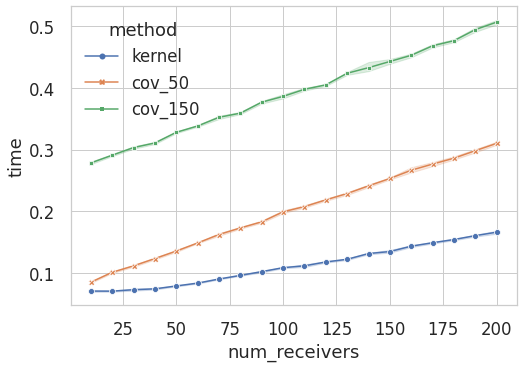

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid",font_scale=1.5)
f, ax = plt.subplots(figsize=(8, 5.5))
sns.lineplot(x="num_receivers", y="time",
             hue="method",style="method",
             data=time_df,
             markers=True, dashes=False)
# plt.savefig('/content/drive/MyDrive/YJ/Green_Stone/figs/ADtime505030.png',dpi=500,bbox_inches='tight')

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

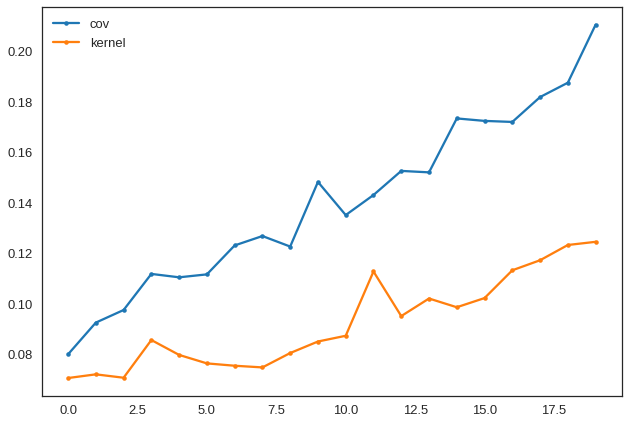

In [ ]:
num_receivers = np.arange(1,100,5)
plt.plot(num_receivers,time_cov_list,'.-',label = 'covolution')
plt.plot(num_receivers,time_kernel_list,'.-',label = 'kernel')
plt.legend()

In [ ]:
model.activate_regular_grid()
g = GravityPreprocessingRegAllLoop(model,model.grid.regular_grid)
tz = g.set_tz_kernel(model.model_radius,model.regular_grid_resolution)
input = model.get_graph_input()
model.create_tensorflow_graph(input,gradient = True)
def hvp(mu,tangents):
    with tf.autodiff.ForwardAccumulator(mu, tangents) as acc:
        with tf.GradientTape(watch_accessed_variables=False) as t:
            t.watch(mu)
            TFG = TFGraph(input, model.fault_drift,
                            model.grid_tensor, model.values_properties, model.nugget_effect_grad,model.nugget_effect_scalar, model.Range,
                            model.C_o, model.rescale_factor,slope = 1, dtype = model.tfdtype, gradient = True)
            formation_block,property_block,block_mask =TFG.compute_series(mu,
                        model.dips_position,
                        model.dip_angles,
                        model.azimuth,
                        model.polarity,
                        model.values_properties)

            size = tf.reduce_prod(model.regular_grid_resolution)

            densities = property_block[0:size]

            center_index_x = tf.constant((g.new_xy_ravel[0]-g.model.extent[0])//g.dx,tf.float32)
            center_index_y = tf.constant((g.new_xy_ravel[1]-g.model.extent[2])//g.dy,tf.float32)
            grav_convolution_full = tf.TensorArray(tf.float32, size=n_devices, dynamic_size=False, clear_after_read=True)
            for i in tf.range(n_devices):
              c_x = tf.cast(center_index_x[i],tf.int32)
              c_y = tf.cast(center_index_y[i],tf.int32)

              windowed_densities = tf.reshape(densities,model.regular_grid_resolution)[c_x-g.radius_cell_x:c_x+g.radius_cell_x+1,c_y-g.radius_cell_y:c_y+g.radius_cell_y+1,:]
              windowed_densities = tf.squeeze(tf.reshape(windowed_densities,(-1,1)))
              grav_ = TFG.compute_forward_gravity(tfconstant(tz), 0, size, windowed_densities)
              grav_convolution_full = grav_convolution_full.write(i, grav_)
            grav_convolution_full = tf.squeeze(grav_convolution_full.stack())

            print('tracing')
            tf.print('executing')
        loss = t.gradient(grav_convolution_full,mu)
    hess = acc.jvp(loss)
    return(hess)

In [ ]:
mu = model.surface_points_coord
tangents = np.zeros(mu.shape)
tangents[0]=1
tangents = tf.convert_to_tensor(tangents,dtype=tf.float32)
start_time = time.time()
hvp(mu,tangents)
print("--- %s seconds ---" % (time.time() - start_time))

tracing
executing
--- 9.035943508148193 seconds ---


In [ ]:
start_time = time.time()
hvp(mu,tangents)
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
hvp(mu,tangents)
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
hvp(mu,tangents)
print("--- %s seconds ---" % (time.time() - start_time))

tracing
executing
--- 8.787880182266235 seconds ---
tracing
executing
--- 8.629806518554688 seconds ---
tracing
executing
--- 9.168853282928467 seconds ---


In [ ]:
start_time = time.time()
hvp(mu,tangents)
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
hvp(mu,tangents)
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
hvp(mu,tangents)
print("--- %s seconds ---" % (time.time() - start_time))

tracing
executing
--- 3.417574405670166 seconds ---
tracing
executing
--- 3.4176459312438965 seconds ---
tracing
executing
--- 3.341977834701538 seconds ---


## cov

In [ ]:
for i in tf.range(20,dtype=tf.int32):
  print(i)

In [ ]:
@tf.function
def foo(x):
  for i in tf.range(tf.constant([2,3,2],tf.int32)[0]):
    a = 4
  return a

foo(2)

In [ ]:
m = tf.constant(3,dtype = tf.float32)
with tf.GradientTape(watch_accessed_variables=False) as t:
  t.watch(m)
  loss = foo(m)
t.gradient(loss,m)


In [ ]:
x